In [1]:
import os
import metnum
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import normalize

## Pruebas

El objetivo principal de esta notebook es entender la relación que hay entre:

* el tamaño del conjunto de entrenamiento (trainset)
* k de knn, para nuestra implementación al clasificar clases
* K de K-fold, como validador del parámetro encontrado teniendo en cuenta las métricas propuestas

Utilizando como punto de comparación las métricas mencionadas. Para ello se hicieron una serie de corridas en las cuales se varian esas variables:

* el trainset tomando las particiones set[0, ..., i * 8400] sobre el total de 42000 elementos del dataset
* k de knn entre [1, ..., 601] en intervalos de 50 unidades
* K de K-fold en el conjunto {5, 10, 15, 20}

## Replica

> :~/../notebooks$ ./knn -h

o bien

> :~/../notebooks$ ./parallelknn


Los resultados quedan en el directorio `knn_results/`.

Para cada una de estas corridas obtuvimos detalles que exploramos a continuación.

## Explorando los datos

Traemos los csv arrojados por las pruebas

In [2]:
data_files = os.listdir('knn_results')

def load_files(filenames):
    for filename in filenames:
        yield pd.read_csv(f"knn_results/{filename}")

data = pd.concat(load_files(data_files), ignore_index=True)

data.describe()

,accuracy,cohen_kappa,f1,kfold,knn,precision,recall,train_size
count,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000,2600.000000
mean,0.865315,0.850022,0.866688,15.000000,301.000000,0.887287,0.865315,21000.000000
std,0.055580,0.061964,0.054313,5.000962,187.118857,0.037646,0.055580,9393.292082
min,0.695238,0.661946,0.694057,5.000000,1.000000,0.784655,0.695238,8400.000000
25%,0.834152,0.815368,0.835576,10.000000,151.000000,0.863952,0.834152,14700.000000
50%,0.869048,0.854290,0.870532,15.000000,301.000000,0.886963,0.869048,21000.000000
75%,0.903348,0.892350,0.903361,20.000000,451.000000,0.911120,0.903348,27300.000000
max,0.972619,0.969548,0.972646,20.000000,601.000000,0.972859,0.972619,33600.000000


## Agrupamiento de datos

Podemos agrupar por train size, knn y kfold para tener una idea general de como quedan los datos

In [3]:
# podemos usar .mean() para resolver las métricas obtenidas de los distintos kfold

grouped = data.groupby(['train_size', 'knn', 'kfold']).mean()

grouped.head(20)

accuracy  cohen_kappa        f1  precision    recall
train_size knn kfold                                                      
8400       1   5      0.941667     0.935125  0.941537   0.942422  0.941667
               10     0.944881     0.938667  0.944836   0.946050  0.944881
               15     0.945952     0.939830  0.945882   0.947084  0.945952
               20     0.947024     0.940979  0.947015   0.948609  0.947024
           51  5      0.896786     0.885179  0.897223   0.905259  0.896786
               10     0.901190     0.890036  0.901563   0.909300  0.901190
               15     0.902619     0.891579  0.902952   0.911111  0.902619
               20     0.902381     0.891245  0.902725   0.911424  0.902381
           101 5      0.867976     0.853091  0.869217   0.884961  0.867976
               10     0.874048     0.859808  0.875166   0.890062  0.874048
               15     0.874762     0.860539  0.875614   0.890484  0.874762
               20     0.875595     0.861388  0.876441   0.891869  0.875595
           151 5      0.843452     0.825769  0.845431   0.868702  0.843452
               10     0.850476     0.833549  0.852181   0.874285  0.850476
               15     0.852619     0.835872  0.854112   0.875772  0.852619
               20     0.853810     0.837114  0.855460   0.877580  0.853810
           201 5      0.825595     0.805864  0.828483   0.858896  0.825595
               10     0.831786     0.812703  0.834310   0.862743  0.831786
               15     0.834405     0.815548  0.836566   0.864102  0.834405
               20     0.835595     0.816771  0.837897   0.866267  0.835595

## Análisis

¿Pero cuál es la mejor combinación? Buscando por media de métrica más alta por ejemplo:

In [4]:
idx = []
metrics = grouped.columns.values

for metric in metrics:
    print(f"Media más alta para {metric}")
    idx = grouped[[metric]].idxmax()[metric]
    print(grouped.loc[idx])
    print("==================")

Media más alta para accuracy
accuracy       0.965595
cohen_kappa    0.961744
f1             0.965561
precision      0.965894
recall         0.965595
Name: (33600, 1, 15), dtype: float64
Media más alta para cohen_kappa
accuracy       0.965595
cohen_kappa    0.961744
f1             0.965561
precision      0.965894
recall         0.965595
Name: (33600, 1, 15), dtype: float64
Media más alta para f1
accuracy       0.965595
cohen_kappa    0.961744
f1             0.965561
precision      0.965894
recall         0.965595
Name: (33600, 1, 15), dtype: float64
Media más alta para precision
accuracy       0.965595
cohen_kappa    0.961744
f1             0.965561
precision      0.965894
recall         0.965595
Name: (33600, 1, 15), dtype: float64
Media más alta para recall
accuracy       0.965595
cohen_kappa    0.961744
f1             0.965561
precision      0.965894
recall         0.965595
Name: (33600, 1, 15), dtype: float64


Observemos que justamente la mejor combinación se dá en el trainset que coincide con la prueba hecha sobre los 42000 elementos del dataset con un 80% utilizados para entrenar, que son 33600 elementos. Utilizar __1-nn__ verificado utilizando cross validation __15-fold__ nos otorga la mayor media en cada métrica obtenida, en particular en el accuracy. Esto dispara la pregunta __¿Por que 15-fold nos dá la mayor certeza al elegir k y no otro?__: para responder esto, podemos graficar el accuracy por ejemplo, en función de los valores que tomó K-fold para distintos tamaños del trainset utilizando 1-nn obtenido previamente. 


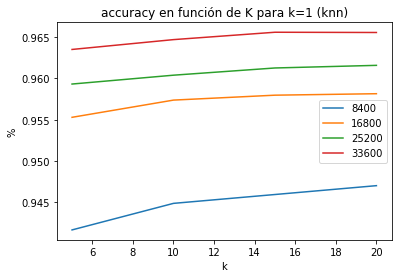

In [19]:
def plot_kfold(metric, knn):
    plt.title(f"{metric} en función de K para k={knn} (knn)")
    plt.xlabel("k")
    plt.ylabel("%")

    sizes = grouped.index.levels[0].values
    xs = grouped.index.levels[2].values

    for size in sizes:
        ys = []
        for x in xs:
            ys.append(grouped.loc[size, knn, x][metric])
        plt.plot(xs, ys)

    plt.gca().legend(tuple(sizes))
    plt.show()

plot_kfold("accuracy", 1)

Se puede observar que el accuracy mejora no solo dependiendo del valor de K (k-fold), si no también del tamaño del trainset que se utilizó. Esto es consistente con la elección hecha previamente: sobre la partición de 42000 elementos (el más grande) y un K (k-fold) de 15.

¿Cómo se comportará el sistema si variamos más k? ¿Habrán otros valores que puedan darnos resultados similares? ¿Depénderá del tamaño del trainset?

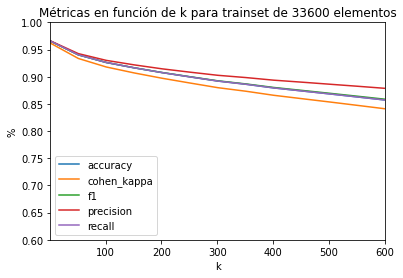

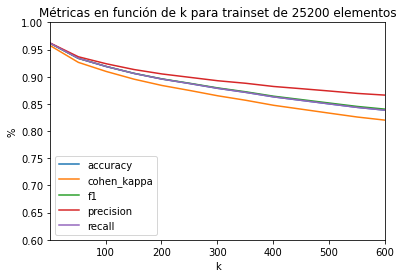

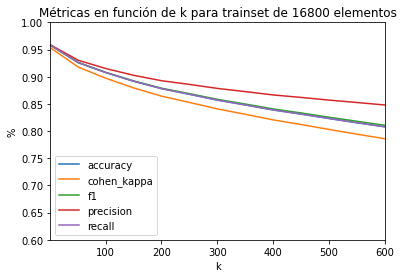

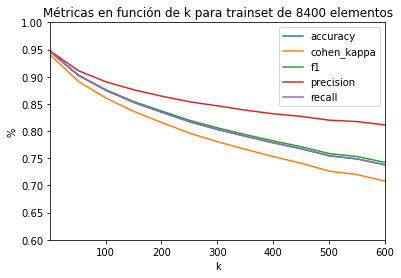

In [20]:
def plot_metric(train_size, kfold):
    xs = grouped.index.levels[1].values
    
    plt.title(f"Métricas en función de k para trainset de {train_size} elementos")
    plt.xlabel("k")
    plt.ylabel("%")

    for metric in metrics:
        ys = []
        for x in xs:
            ys.append(grouped.loc[train_size, x, kfold][metric])
        plt.plot(xs, ys)

    plt.axis([1, xs[-1], 0.6, 1])
    plt.gca().legend(tuple(metrics))
    plt.show()

plot_metric(33600, 15)
plot_metric(25200, 15)
plot_metric(16800, 15)
plot_metric(8400, 15)


Independientemente del tamaño del trainset, conforme se agregan más vecinos para checkear, menor capacidad de predicción tiene el sistema, mirándo cualquier métrica. Esto corrobora que nuestra mejor elección es tomar 1 vecino.

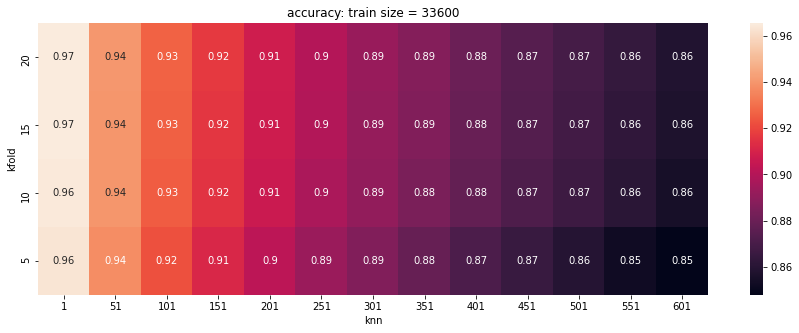

In [21]:
def pltHeatmap(train_size, metric):
    df = grouped.loc[train_size].unstack(level=0)[metric]
    fig, ax = plt.subplots(figsize=(15,5))
    sns.heatmap(df, annot = True, ax=ax).invert_yaxis()
    plt.title(f"{metric}: train size = {train_size}")
    plt.show()

# train_sizes = pd.unique(data['train_size'])
# [ 8400 16800 25200 33600]

# metrics = grouped.columns.values
# ['accuracy' 'cohen_kappa' 'f1' 'precision' 'recall']

pltHeatmap(33600, "accuracy")

Analogamente, en este heatmap, se ve de manera muy visual la relación que se mencionaba, y si imaginamos que este es el dominio de la función para optimizar el sistema, en la region comprendida por los primeros 2x2 bloques se encuentra la mayor oportunidad para mejorar el accuracy, por lo que valdria la pena aumentar la granularidad en esa región. Notemos también que el accuracy parece ser creciente en relación a cuantas particiones se utilizan para hacer cross validation, pero decreciente en relación a la cantidad de vecinos por lo que a priori no se podría mejorar más el sistema (no se puede tener 0 vecinos) si no aumentar la confianza que tenemos en él midiendo el accuracy aumentando las particiones para validar.

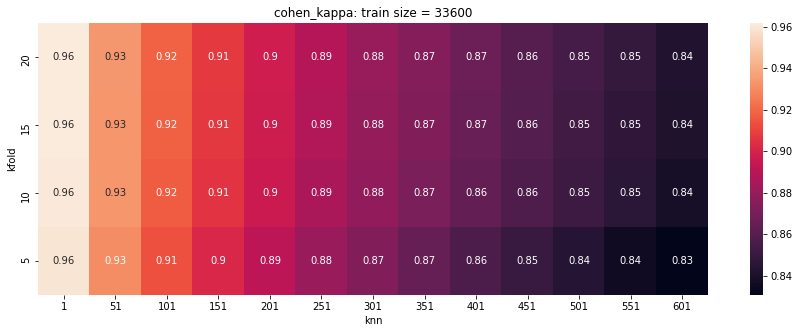

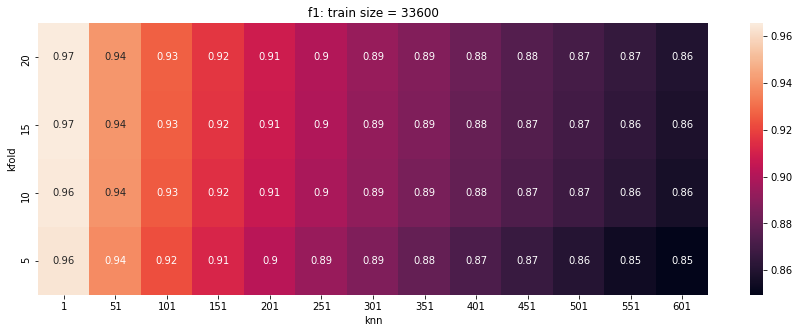

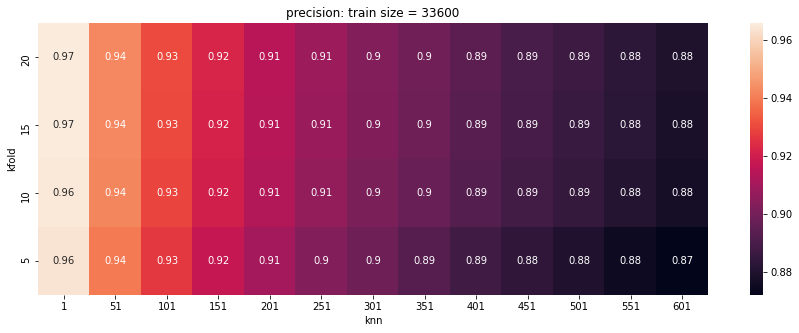

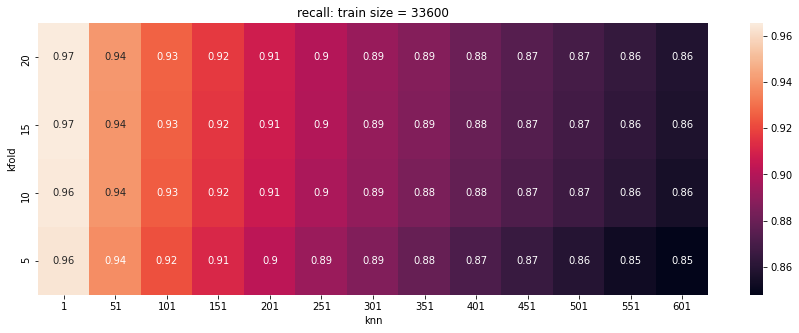

In [22]:
pltHeatmap(33600, "cohen_kappa")
pltHeatmap(33600, "f1")
pltHeatmap(33600, "precision")
pltHeatmap(33600, "recall")

Como se mencionó previamente, lo mismo sucede si miramos las demás métricas.

¿Pasará lo mismo para el accuracy con la partición más chica con la que se corrió el experimento? Train size de 8400 elementos:

In [23]:
grouped.loc[8400].sort_values(by="accuracy", ascending=False).head(20)

accuracy  cohen_kappa        f1  precision    recall
knn kfold                                                      
1   20     0.947024     0.940979  0.947015   0.948609  0.947024
    15     0.945952     0.939830  0.945882   0.947084  0.945952
    10     0.944881     0.938667  0.944836   0.946050  0.944881
    5      0.941667     0.935125  0.941537   0.942422  0.941667
51  15     0.902619     0.891579  0.902952   0.911111  0.902619
    20     0.902381     0.891245  0.902725   0.911424  0.902381
    10     0.901190     0.890036  0.901563   0.909300  0.901190
    5      0.896786     0.885179  0.897223   0.905259  0.896786
101 20     0.875595     0.861388  0.876441   0.891869  0.875595
    15     0.874762     0.860539  0.875614   0.890484  0.874762
    10     0.874048     0.859808  0.875166   0.890062  0.874048
    5      0.867976     0.853091  0.869217   0.884961  0.867976
151 20     0.853810     0.837114  0.855460   0.877580  0.853810
    15     0.852619     0.835872  0.854112   0.875772  0.852619
    10     0.850476     0.833549  0.852181   0.874285  0.850476
    5      0.843452     0.825769  0.845431   0.868702  0.843452
201 20     0.835595     0.816771  0.837897   0.866267  0.835595
    15     0.834405     0.815548  0.836566   0.864102  0.834405
    10     0.831786     0.812703  0.834310   0.862743  0.831786
    5      0.825595     0.805864  0.828483   0.858896  0.825595

Efectivamente, sucede lo mismo, pero ahora no solo notamos que la relación entre la métrica y el accuracy está dada por la cantidad de vecinos que se tome en cuenta y la cantidad de parciones para hacer cross validation, si no también por el train size, dado que al ser esta la partición más chica que disponemos con la que hicimos las pruebas, tiene también los valores más bajos para el accuracy. Veamos más graficamente dejando fija la variable que aporta a la confianza que tenemos en el sistema, la cantidad de particiones en 20:

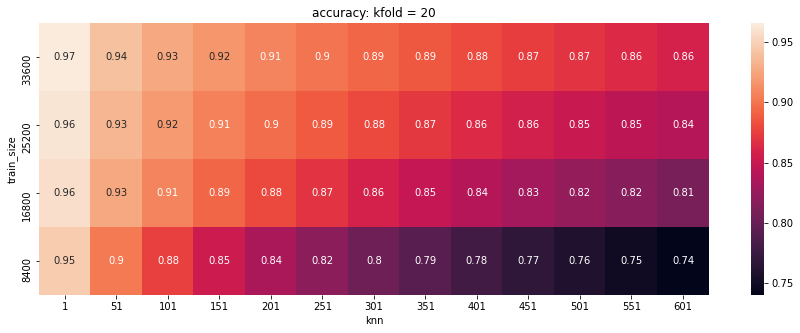

In [24]:
grouped = data.groupby(['kfold','knn','train_size']).mean()
df = grouped.loc[20].unstack(level=0)["accuracy"]
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(df, annot = True, ax=ax).invert_yaxis()
plt.title(f"accuracy: kfold = 20")
plt.show()

Observemos que el accuracy disminuye no solo aumentando la cantidad de vecinos, si no también si la cantidad de elementos del train set es menor, como se había mencionado.

### Errores y otras mediciones

Una vez hallado el mejor k (k-nn), validado por mediante K-fold cross validation, podemos utilizarlo para indagar un poco sobre las métricas de recall y precision por clase.

In [25]:
df_train = pd.read_csv("../data/train.csv")
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((42000, 784), (42000, 1))

In [26]:
df_train["label"].value_counts(normalize=True)

1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: label, dtype: float64

In [27]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

Ahora tengo 33600 instancias de entrenamiento y 8400 de validación


In [28]:
clf = metnum.KNNClassifier(1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

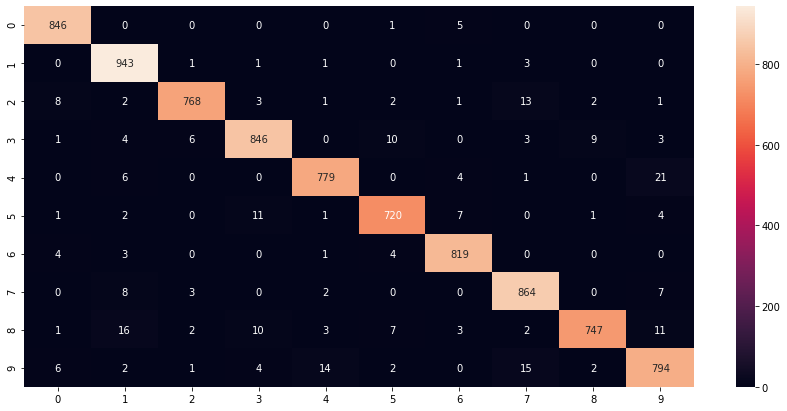

In [29]:
report = classification_report(y_val, y_pred, output_dict=True)
confusion = confusion_matrix(y_val, y_pred)

df = pd.DataFrame(confusion)
plt.figure(figsize = (15,7))
sns.heatmap(df, annot=True, fmt='g')
plt.show()

Como era de esperar en un clasificador con accuracy alto, hay muy buenas predicciones en tanto se notan también algunas malas que vamos a resaltar a continuación.

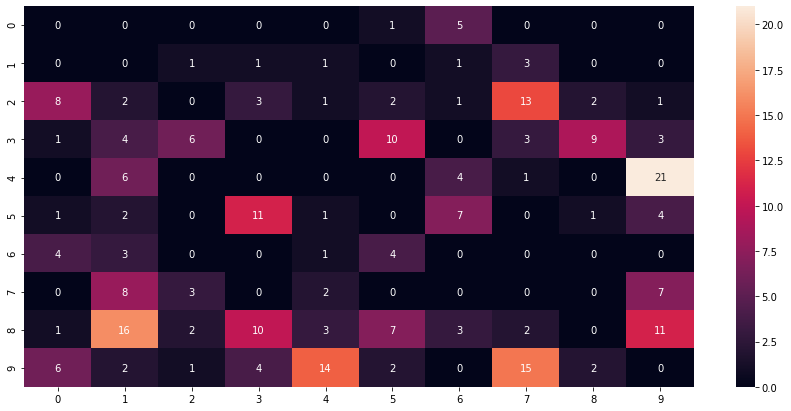

In [31]:
np.fill_diagonal(df.values, 0)
plt.figure(figsize = (15,7))
sns.heatmap(df, annot=True, fmt='g')
plt.show()

Podemos observar que hay en orden de magnitud errores clasificando:

* 9 -> 4: 21
* 1 -> 8: 16
* 7 -> 9: 15
* 4 -> 9: 15
* 7 -> 2: 13
* 9 -> 8: 11
* 3 -> 5: 11
* 5 -> 3: 10
* 3 -> 8: 10

__¿A qué puede deberse?__ __¿Podríamos mejorarlo una vez tengamos implementado PCA?__

¿Podemos establecer una relación entre los errores que vemos y las métricas por clase?

/home/lggomez/.pyenv/versions/3.6.5/envs/metnum-tp2/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


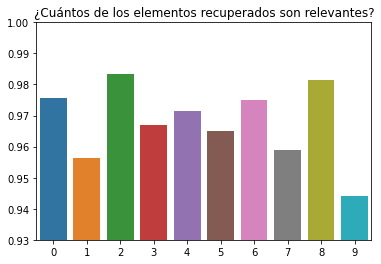

/home/lggomez/.pyenv/versions/3.6.5/envs/metnum-tp2/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


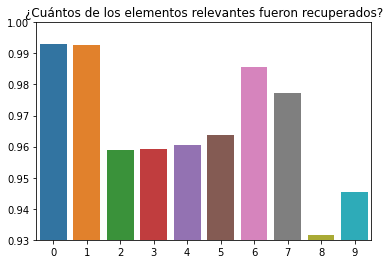

/home/lggomez/.pyenv/versions/3.6.5/envs/metnum-tp2/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


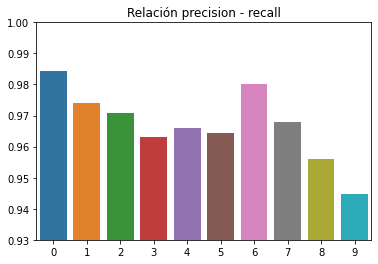

In [34]:
def get_data(metric):
    digits = 10
    xs = np.arange(0, digits)
    ys = np.array([])
    for i in range(digits):
        ys = np.append(ys, report[str(xs[i])][metric])
    return xs, ys

def plot_metric(metric, title="sintitulo"):
    xs, ys = get_data(metric)
    sns.barplot(xs, ys)
    plt.ylim(0.93, 1)
    plt.title(title)
    plt.show()

plot_metric("precision", title="¿Cuántos de los elementos recuperados son relevantes?")
plot_metric("recall", title="¿Cuántos de los elementos relevantes fueron recuperados?")
plot_metric("f1-score", title="Relación precision - recall")

### ¿Por qué con 1-nn  se logran los mejores resultados? ¿Es válido para cualquier sistema?

Vimos que en todos los casos presentados del sistema, tomar 1-nn es lo mejor que podemos hacer. Hablamos de un único vecino. Respecto a la cantidad de vecinos máxima: si suponemos que las clases están balanceadas al entrenar, podemos decir entonces que tenemos aproximadamente n elementos por cada una de ellas, de esta forma, midiendo los votos de los vecinos solo por presencia (la forma más naive), bastaría con tomar 2n elementos para que la posibilidad de la mala clasificación sea más concreta ya que podria estar contando los votos de otro cluster en el espacio j-dimensional. Esto puede pasar especialmente cuando los dígitos en cuestión se parecen, como podria ser el caso del 3 y el 8, o bien el 1 y el 7. En base a esto y al sistema con el que contamos, sobre el train set de 33600 elementos que vimos previamente, tendriamos aproximadamente 3360 elementos de cada clase, con lo que utilizando 6720-nn podríamos tener un accuracy cercano a 0. (habría que probar esto).